# Modelling of antibodies-like

**Author**: Dr. Alexis Salas Burgos
**Laboratory**: Nanocell Lab
**Date**: May 2019
**Version**: 2.0

https://en.wikipedia.org/wiki/Single-chain_variable_fragment
* A single-chain variable fragment (scFv) is not actually a fragment of an antibody, but instead is a fusion protein of the variable regions of the heavy (VH) and light chains (VL) of immunoglobulins, connected with a short linker peptide of ten to about 25 amino acids. 
* The linker is usually rich in glycine for flexibility, as well as serine or threonine for solubility, and can either connect the N-terminus of the VH with the C-terminus of the VL, or vice versa.

## Requirements

**Software**
* modeller
> export KEY_MODELLER=MODELIRANJE
> conda install -c salilab modeller
* mafft
> conda install -c biocore mafft 
* dssp
> conda install -c salilab dssp

**Python**
* biopython
> conda install biopython
* prody 
> pip install prody

## Query Sequences

Separated into light and heavy fragment constant

In [4]:
seqMH    = "MAETQLLESGGGLVQPGGSLRLSCAYSSSSTYYYSMSWVRQAPGKGLEWSSSYSSSYSGYTGYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYQETCETYNADYWGQGTLVTVS"
seqML    = "STDIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCYSYYYYYYTFGQGTKVEIK"
linker   = "SGGGGSGGGGSGGGG"
his_tail = "HHHHHH"

pdb_temp = "2fjh"
chain_H  = "H"
chain_L  = "L"

## Create the Alignment

In [5]:
def read_ali(output="output"):
    from Bio import SeqIO
    handle_ali = open(output, "r")
    seqs = SeqIO.parse(handle_ali, "fasta")
    seqs_ali  = []
    names_ali = []
    for seq in seqs:
        seqs_ali.append(seq.seq)
        names_ali.append(seq.id)
    return seqs_ali, names_ali

In [6]:
def get_gaps_index(seq_ali):
    import re
    rcp = re.compile("-+")
    s = str(seq_ali)
    find = rcp.findall(s)
    gaps_index = []
    for gap in find:
        gaps_index.append(s.index(gap))
    return gaps_index

In [7]:
import prody
import os

# pdb_temp
structure = prody.parsePDB(pdb_temp)
# chain_H
seqH = structure[chain_H].getSequence()
# chain_L
seqL = structure[chain_L].getSequence()


with open("seq2aliH.fa", "w") as f:
    f.write(">tempH\n%s\n" % seqH)
    f.write(">model\n%s\n" % seqMH)

with open("seq2aliL.fa", "w") as f:
    f.write(">tempL\n%s\n" % seqL)
    f.write(">model\n%s\n" % seqML)

cmdH = "mafft --auto seq2aliH.fa > outputH.ali"
os.system(cmdH)
seqs_aliH, names_aliH = read_ali("outputH.ali")

cmdL = "mafft --auto seq2aliL.fa > outputL.ali"
os.system(cmdL)
seqs_aliL, names_aliL = read_ali("outputL.ali")

#print seqs_aliH[1]
#print seqs_aliL[1]

gaps1 = get_gaps_index(seqs_aliH[1])
print (seqs_aliH[0][:gaps1[-1]])
limit_H =  len(seqs_aliH[0][:gaps1[-1]]) - seqs_aliH[0][:gaps1[-1]].count("-")

gaps2 = get_gaps_index(seqs_aliL[1])
print (seqs_aliL[0][:gaps2[-1]])
limit_L =  len(seqs_aliL[0][:gaps2[-1]]) - seqs_aliL[0][:gaps2[-1]].count("-")

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2fjh downloaded (2fjh.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 8103 atoms and 1 coordinate set(s) were parsed in 0.06s.


--EVQLVESGGGLVQPGGSLRLSCAASGFTINASWIHWVRQAPGKGLEWVGAI-YPYSGYTNYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARWGHSTSPWAMDYWGQGTLVTVS
--DIQMTQSPSSLSASVGDRVTITCRASQVIRRSLAWYQQKPGKAPKLLIYAASNLASGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQSNTSPLTFGQGTKVEIK


In [8]:
import prody
# pdb_temp
structure = prody.parsePDB(pdb_temp)
atoms1 = structure.select("chain H and resnum 0 to %d" % limit_H)
atoms1.setChids("A")
atoms2 = structure.select("chain L and resnum 0 to %d" % limit_L)
atoms2.setChids("A")
atomsF = atoms1 + atoms2
prody.writePDB("%sHL.pdb"% (pdb_temp), atomsF)

@> PDB file is found in working directory (2fjh.pdb.gz).
@> 8103 atoms and 1 coordinate set(s) were parsed in 0.07s.


'2fjhHL.pdb'

## Create the PIR file

* Sequence en model in PIR format "scfv.fa"
* Alignment in PIR format "scfv.ali"

In [9]:
#Modelo
SEQH =  seqs_aliH[1][:gaps1[-1]]
SEQL = seqs_aliL[1][:gaps2[-1]]
MSEQ_FINAL = SEQH + linker + SEQL + his_tail

#Templado
TSEQ_FINAL = seqs_aliH[0][:gaps1[-1]]+("-"*len(linker))+seqs_aliL[0][:gaps2[-1]]+("-"*len(his_tail))

with open("scfv.ali", "w") as f:
    name =  "2fjhHL"
    f.write(">P1;%s\n" % name)
    f.write("structureX:%s.pdb: %d:A:%s: A:::0.00: 0.00\n" % (name, 1, "@"))
    f.write(str(TSEQ_FINAL))
    f.write("*\n")
    
    name =  "scfv"
    f.write(">P1;%s\n" % name)
    f.write("sequenceX:%s: %d:A:%s: A:::0.00: 0.00\n" % (name, 1, "@"))
    f.write(str(MSEQ_FINAL))
    f.write("*\n")

with open("scfv.fa", "w") as f2:
    f2.write(">P1;%s\n" % name)
    f2.write("sequence:%s: %d:A:%s: A:::0.00: 0.00\n" % (name, 1, "@"))
    seqM_final = str(MSEQ_FINAL).replace("-", "") 
    f2.write(str(MSEQ_FINAL))
    f2.write("*\n")

In [10]:
%more scfv.ali

>P1;2fjhHL
structureX:2fjhHL.pdb: 1:A:@: A:::0.00: 0.00
--EVQLVESGGGLVQPGGSLRLSCAASGFTINASWIHWVRQAPGKGLEWVGAI-YPYSGYTNYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARWGHSTSPWAMDYWGQGTLVTVS-----------------DIQMTQSPSSLSASVGDRVTITCRASQVIRRSLAWYQQKPGKAPKLLIYAASNLASGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQSNTSPLTFGQGTKVEIK------*
>P1;scfv
sequenceX:scfv: 1:A:@: A:::0.00: 0.00
MAETQLLESGGGLVQPGGSLRLSCAYSSSSSYYYSMSWVRQAPGKGLEWSSSYSSSYSGYTGYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYQ-----ETCETYNADYWGQGTLVTVSSGGGGSGGGGSGGGGSTDIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCYSYYYYYYTFGQGTKVEIKHHHHHH*


## Build the models

In [11]:
from modeller import *
from modeller.automodel import *

env = environ()
a = automodel(env, alnfile='scfv.ali',
              knowns=["2fjhHL"], sequence="scfv",
              assess_methods=(assess.DOPE, assess.GA341))
a.starting_model = 1
a.ending_model = 3
a.make()


                         MODELLER 9.21, 2018/12/06, r11301

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2018 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, Darwin MacBook-Pro-de-Alexis.local 18.6.0 x86_64
Date and time of c

## Seleccionar el mejor modelo

In [12]:
def do_profile(name):
    from modeller import environ, selection
    from modeller.scripts import complete_pdb

    log.verbose()    # request verbose output
    env = environ()
    env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
    env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters
    
    # read model file
    mdl = complete_pdb(env, '%s.pdb'%name)

    # Assess with DOPE:
    s = selection(mdl)   # all atom selection
    s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='%s.profile' %name,
                  normalize_profile=True, smoothing_window=15)

    return

In [13]:
modelsel = 3
from modeller import *
from modeller.automodel import *

pdb_model_name = '%s.B9999000%d' % (name, modelsel)
pdb_template_name = '%s' % ("2fjhHL")

do_profile(pdb_model_name)
do_profile(pdb_template_name)

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12515140   12221.816    11.935

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12515668   12222.332    11.936
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12564268   12269.793    11.982
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12577568   12282.781    11.995
openf___224_> Open           $

## Obtain DSSP information

Code from dssp

    H = alpha helix
    B = residue in isolated beta-bridge
    E = extended strand, participates in beta ladder
    G = 3-helix (3/10 helix)
    I = 5 helix (pi helix)
    T = hydrogen bonded turn
    S = bend


In [16]:
def do_dssp(pdbIN):
    import os
    dssp = "/Users/alsalas/anaconda3/bin/mkdssp"
    comando = "%s -i %s.pdb -o %s.dssp" % (dssp, pdbIN, pdbIN)
    os.system(comando)
    
    with open("%s.dssp"%pdbIN, "r") as f:
        #head = "#  RESIDUE AA STRUCTURE BP1 BP2  ACC     N-H-->O    O-->H-N    N-H-->O    O-->H-N    TCO  KAPPA ALPHA  PHI   PSI    X-CA   Y-CA   Z-CA"
        #print [x for x in head.split(" ") if len(x) > 0]
        residue_num  = [0]
        residue_name = ""
        structure2D  = ""
        resnumber = 0
        for l in f.readlines()[25:]:
            residue_name += l[13]
            structure2D  += l[16]
            try:
                resnumber0 = residue_num[-1]
                resnumber = int(l[6:10])
                residue_num.append(resnumber)
            except:
                residue_name = residue_name[:-1]
                structure2D  = structure2D[:-1]
                resnumber0 = residue_num[-1]
            
            if resnumber - resnumber0 > 1:
                gap = "-"*(resnumber-resnumber0-1)
                residue_name = residue_name[:-1]+gap+residue_name[-1]
                structure2D = structure2D[:-1]+gap+structure2D[-1]
     
    return residue_name,structure2D

In [17]:
seq, structure2D = do_dssp("2fjhHL")
print (len(structure2D))
structure2D_gaps = ""
counter = 0
for aa in str(TSEQ_FINAL):
    if aa == "-":
        structure2D_gaps += "-"
    else:
        structure2D_gaps += structure2D[counter]
        counter +=1

231


In [18]:
def get_2dprofile(structure2D, value=-0.04):
    valsH = [None]
    for e in structure2D:
        if e == "E":
            valsH.append(value)
        else:
            valsH.append(None)
    
    valsS = [None]
    for e in structure2D:
        if e == "S":
            valsS.append(value)
        else:
            valsS.append(None)
    
    valsT = [None]
    for e in structure2D:
        if e == "T":
            valsT.append(value)
        else:
            valsT.append(None)
    #print valsH
    return valsH, valsS, valsT
    
def get_profileline(structure2D):
    vals = [None]
    for e in structure2D:
        vals.append(-0.03)
    return vals

def get_rangeprofile(structure2D, lista, value=-0.05):
    valsR = [None]
    largo = len(structure2D)
    j = 0
    counter = 0
    end = 100
    for i in range(largo):
        if counter > end and (j< len(lista)-1):
            j += 1
        start = lista[j][0]
        end = lista[j][1]
        
        if (counter >= start) and (counter <= end):
            valsR.append(value)
        else:
            valsR.append(None)
        counter += 1
    #print valsR
    return valsR

## Plot DOPE with 2D

In [19]:
%matplotlib inline
import pylab
import modeller

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12515140   12221.816    11.935

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12515668   12222.332    11.936
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12564268   12269.793    11.982
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12577568   12282.781    11.995
openf___224_> Open           $

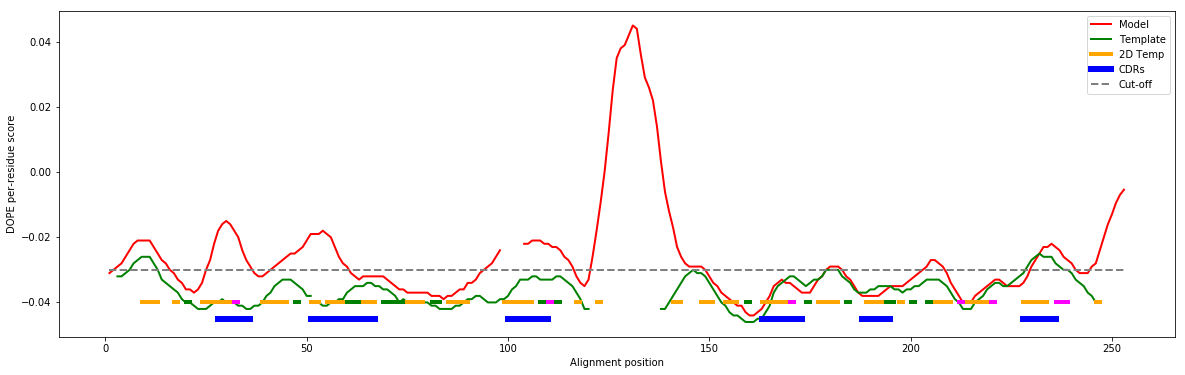

In [20]:
def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals

e = modeller.environ()
a = modeller.alignment(e, file='%s.ali' % name)
template = get_profile('%s.profile' % pdb_template_name, a[pdb_template_name])
model = get_profile('%s.profile' % pdb_model_name, a[name])

#Plot CDR ranges
import numpy as np
cdrH = np.array([[27,35],[50,66],[99,109]])
cdrL = np.array([[24,34],[49,56],[89,97]])+len(SEQH + linker)
lista = np.append(cdrH, cdrL, 0)
cdr   = get_rangeprofile(structure2D_gaps, lista, value=-0.045)

#secondary elements
sheet, beta, turn = get_2dprofile(structure2D_gaps)
line_cutoff = get_profileline(structure2D_gaps)

# Plot the template and model profiles in the same plot for comparison:
pylab.figure(1, figsize=(20,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(template, color='green', linewidth=2, label='Template')


pylab.plot(sheet, color='orange', linewidth=4, label='2D Temp')
pylab.plot(beta, color='magenta', linewidth=4)
pylab.plot(turn, color='green', linewidth=4)
pylab.plot(cdr, color='blue', linewidth=6, label='CDRs')
pylab.plot(line_cutoff, color='gray', linestyle='--', linewidth=2, label='Cut-off')

pylab.legend()
pylab.savefig('dope_profile.png', dpi=65)

## Loop refinenment

In [21]:
 # Loop refinement of an existing model
from modeller import *
from modeller.automodel import *

log.verbose()
env = environ()

# directories for input atom files
env.io.atom_files_directory = './:../atom_files'

# Create a new class based on 'loopmodel' so that we can redefine
# select_loop_atoms (necessary)
class MyLoop(loopmodel):
    # This routine picks the residues to be refined by loop modeling
    def select_loop_atoms(self):
        # 10 residue insertion 
        #return selection(self.residue_range('58', '74'))
        return
m = loopmodel(env,
              alnfile='scfv.ali',
              knowns=["2fjhHL"], 
              sequence="scfv")          # code of the target

m.starting_model= 1                 # index of the first model 
m.ending_model  = 1                 # index of the last model

m.loop.starting_model= 1           # index of the first loop model 
m.loop.ending_model  = 10          # index of the last loop model
m.loop.md_level = refine.fast # loop refinement method; this yields
                                   # models quickly but of low quality;
                                   # use refine.slow for better models

m.make()

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12900418   12598.064    12.303

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12900946   12598.580    12.303
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12949546   12646.041    12.350
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     12962846   12659.029    12.362
openf___224_> Open           $

In [27]:
loopsel = 4
pdb_loopref_name = "%s.BL%04d0003" % (name, loopsel)
do_profile(pdb_loopref_name)
seq_Loop, structure2D_Loop = do_dssp(pdb_loopref_name)

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v19}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v19}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11239320   10975.898    10.719

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11239848   10976.414    10.719
openf___224_> Open           ${MODINSTALL9v19}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11288448   11023.875    10.766
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v19}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11301748   11036.863    10.778
openf___224_> Open           $

FileNotFoundError: [Errno 2] No such file or directory: 'scfv.BL00040003.dssp'

In [28]:
def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals

e = modeller.environ()
a = modeller.alignment(e, file='%s.ali' % (name))
template = get_profile('%s.profile' % pdb_template_name, a[pdb_template_name])
model    = get_profile('%s.profile' % pdb_model_name, a[name])
loop     = get_profile('%s.profile' % pdb_loopref_name, a[name])  

#secondary elements template
helix, beta, turn    = get_2dprofile(structure2D)
#secondary elements model
helixL, betaL, turnL = get_2dprofile(structure2D_Loop, -0.045)
#Cut-off line
line_cutoff = get_profileline(structure2D)


#Plot CDR ranges
# los CDR son obtenidos desde el análisis 
import numpy as np
cdrH = np.array([[27,35],[50,66],[99,109]])
cdrL = np.array([[24,34],[49,56],[89,97]])+len(SEQH + linker)
lista = np.append(cdrH, cdrL, 0)
cdr   = get_rangeprofile(structure2D_gaps, lista, value=-0.050)

# Plot the template and model profiles in the same plot for comparison:
pylab.figure(1, figsize=(20,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(template, color='green', linewidth=2, label='Template')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(loop, color='blue', linewidth=2, label='Loop')

#pylab.plot(helix, color='orange', linewidth=8, label='2D')
#pylab.plot(beta, color='magenta', linewidth=8)
#pylab.plot(turn, color='green', linewidth=8)

pylab.plot(helixL, color='orange', linewidth=8,label='2D')
pylab.plot(betaL, color='magenta', linewidth=8)
pylab.plot(turnL, color='green', linewidth=8)
pylab.plot(cdr, color='blue', linewidth=8, label='CDRs')



pylab.plot(line_cutoff, color='gray', linestyle='--', linewidth=2, label='Cut-off')

pylab.legend()
pylab.savefig('dope_profileFull.png', dpi=65)

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v19}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v19}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11239320   10975.898    10.719

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11239848   10976.414    10.719
openf___224_> Open           ${MODINSTALL9v19}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11288448   11023.875    10.766
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v19}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     11301748   11036.863    10.778
openf___224_> Open           $

NameError: name 'structure2D_Loop' is not defined

## Cleaning the folder

In [69]:
import os,datetime, shutil
archivos = [x for x in os.listdir(".") if (x.count(".ipynb")==0 and os.path.isdir(x)==False)]
dt = str(datetime.datetime.now())
folder_file = "01_modelling_antibody_like_%s" % dt
os.mkdir(folder_file)
for f in archivos:
    shutil.move(f, folder_file)